# Исследование объявлений о продаже квартир

В распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Откройте файл с данными и изучите общую информацию. 

In [2]:
data = pd.read_csv('datasets/real_estate_data.csv', sep='\t')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


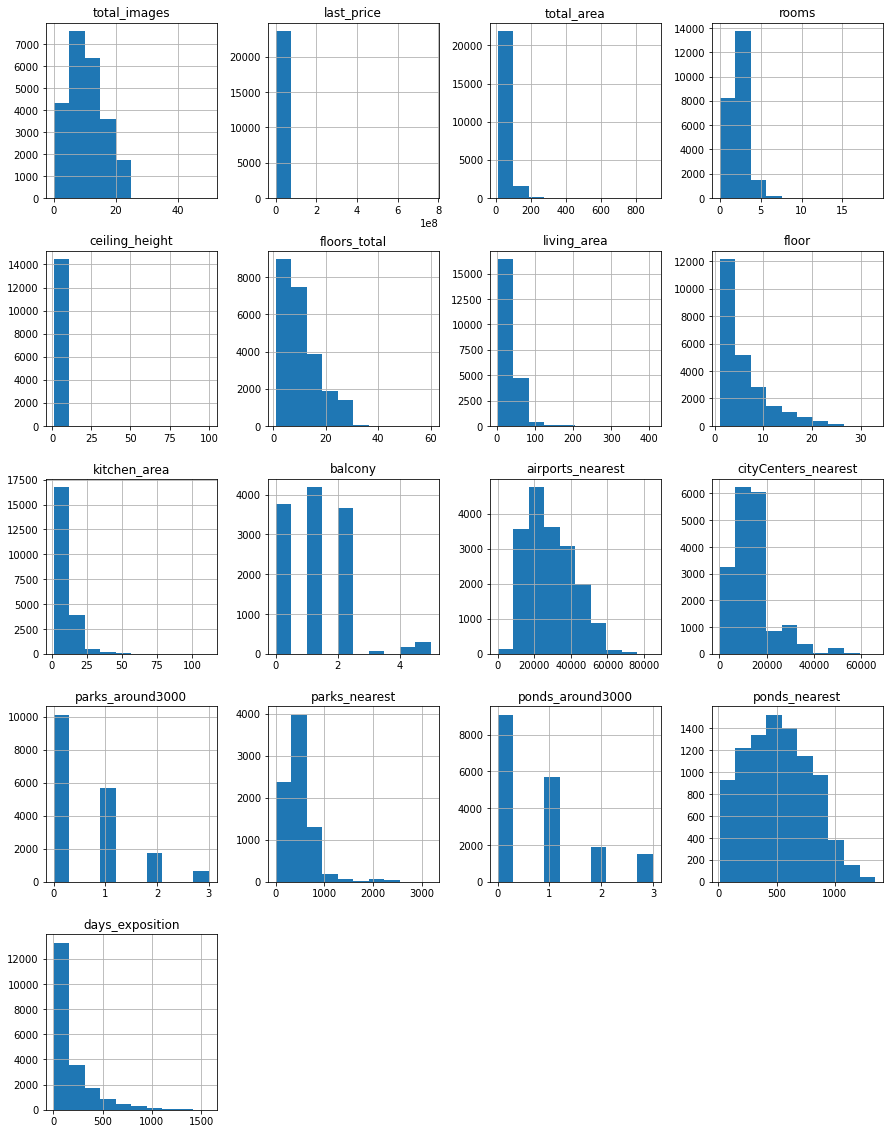

In [5]:
data.hist(figsize=(15, 20));

**Вывод:** датасет состоит из 22 колонок и 23699 строк, содержит пропуски в 14 столбцах, в 6 столбцах необходимо изменить тип данных.

### Предобработка данных

#### Пропущенные значения

In [6]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [7]:
pd.DataFrame(round((data.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.800000
floors_total,0.360000
living_area,8.030000
floor,0.000000
is_apartment,88.290000


Пропущенные значения обнаружены в следующих столбцах:
- `'ceiling_height'` - 9195 шт.
- `'floors_total'` - 86 шт.
- `'living_area'` - 1903 шт.
- `'is_apartment'` - 20924 шт.
- `'kitchen_area'` - 2278 шт.
- `'balcony'` - 11519 шт.
- `'locality_name'` - 49 шт.
- `'airports_nearest'` - 5542 шт.
- `'cityCenters_nearest'` - 5519 шт.
- `'parks_around3000'` - 5518 шт.
- `'parks_nearest'` - 15620 шт.
- `'ponds_around3000'` - 5518 шт.
- `'ponds_nearest'` - 14589 шт.
- `'days_exposition'` - 3181 шт.

Скорее всего данные о высоте потолков и апартаментов были необязательны для заполнения, поэтому пропуски в столбце `'ceiling_height'` можно заменить медианой (+/- высота всегда одинаковая), а по столбцу `'is_apartment'` следует посчитать долю пропусков (потому что их слишком много) и возможно удалить его.

Если продавец не указал число балконов, число парков и парковки рядом, то, скорее всего, в его квартире нет балконов и рядом нет ни парков, ни парковок. В таких столбцах логичнее будет заменить пропуски на 0.

Что касается пропущенных значений общего кол-ва этажей в доме и названий населенных пунктов, скорее всего их случайно не отметили, либо произошел технический сбой, так как их невозможно восстановить и их количество достаточно мало, следует их удалить.

Пропущенные данные о жилой площади и площади кухни можно заменить медианами относительно кол-ва комнат (так как этот показатель больше всего на это влияет). Стоит отметить, что площадь кухни в студиях можно приравнять к 0.

Пропуски в столбце с кол-вом дней публикации могут говорить о том, что сделка по покупке квартиры была закрыта в день публикаци, поэтому пропуски можно заменить 0.

Группа столбцов `'cityCenters_nearest'`, `'airports_nearest'`, `'parks_nearest'` и `'ponds_nearest'` содержит в себе расстояния до какого-либо объекта, пропуски в них скорее всего обусловлены тем, что в соответствующих населенных пунктах нет этих объектов, но заменять нулем не правильно (потому как это может означать, что объект находится совсем рядом) не могу предложить другую логичную замену, а удалять такое кол-во данных не считаю целесообразным, поэтому оставлю их пустыми.

In [8]:
# Замена пропусков в столбце 'ceiling_height' медианным значением
data.ceiling_height = data.ceiling_height.fillna(data.ceiling_height.median())

In [9]:
# Удаление строк с пропусками в столбцах ['floors_total', 'locality_name']
data = data.dropna(subset=['floors_total', 'locality_name']).reset_index(drop=True)

In [10]:
# Замена пропущенных значений жилой площади на медиану относительно кол-ва комнат
for t in data.rooms.unique():
    data.loc[(data.rooms == t) & (data.living_area.isna()), 'living_area'] = \
    data.loc[(data.rooms == t), 'living_area'].median()

In [11]:
# Процент пропущенных значений 'is_apartment'
print(data.is_apartment.isna().sum() / len(data.is_apartment) * 100)

88.28771483131763


In [13]:
# Замена пропущенных значений в столбце 'is_apartment' на False
data.loc[data.is_apartment.isna(), 'is_apartment'] = False

In [14]:
# Замена пропущенных значений площади кухни в студиях на 0
data.loc[data.studio == True, 'kitchen_area'] = 0

In [15]:
# Замена пропущенных значений площади кухни на медиану относительно кол-ва комнат
for t in data.rooms.unique():
    data.loc[(data.rooms == t) & (data.kitchen_area.isna()), 'kitchen_area'] = \
    data.loc[(data.rooms == t), 'kitchen_area'].median()

In [16]:
# Замена пропусков 'balcony'
data.balcony = data.balcony.fillna(0)

#### Изменение типов данных

Типы данных необходимо изменять потому, что используя неправильные типы можно получить неожиданные результаты и/или ошибки.

Данные необходимо пометь в следующих столбцах:
- `'first_day_exposition'`
- `'floors_total'`
- `'balcony'`
- `'parks_around3000'`
- `'ponds_around3000'`
- `'days_exposition'`

Так как в столбце `'first_day_exposition'` хранится информация о дате и времени публикации, тип `'object'` необходимо привести к типу `'datetime'`, в остальных столбцах подразумеваются целочисленные данные, поэтому тип `'float'` лучше привести к типу `'int'`.

In [20]:
# Изменение типа данных в столбце 'first_day_exposition': 'object' in 'date_time' 
data.first_day_exposition = pd.to_datetime(data.first_day_exposition, format='%Y-%m-%dT%H:%M:%S')

In [21]:
# Изменение типа данных в столбце 'floors_total': float in int
#data.floors_total = data.floors_total.astype(int)
data.floors_total = pd.to_numeric(data.floors_total, downcast='integer', errors='coerce')

In [22]:
# Изменение типа данных в столбце 'balcony': float in int
# data.balcony = data.balcony.astype(int)
data.balcony = pd.to_numeric(data.balcony, downcast='integer',  errors='coerce')

In [23]:
# Изменение типа данных в столбце 'parks_around3000': float in int
# data.parks_around3000 = data.parks_around3000.astype(int)
data.parks_around3000 = pd.to_numeric(data.parks_around3000, downcast='integer',  errors='coerce')

In [24]:
# Изменение типа данных в столбце 'ponds_around3000': float in int
# data.ponds_around3000 = data.ponds_around3000.astype(int)
data.ponds_around3000 = pd.to_numeric(data.ponds_around3000, downcast='integer',  errors='coerce')

In [25]:
# Изменение типа данных в столбце 'days_exposition': float in int
# data.days_exposition = data.days_exposition.astype(int)
data.days_exposition = pd.to_numeric(data.days_exposition, downcast='integer',  errors='coerce')

In [26]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64

#### Удаление неявных дубликатов в столбце `'locality_name'`

In [27]:
data.locality_name.nunique()

364

In [28]:
# Замена букв
data.locality_name = data.locality_name.str.replace('ё', 'е', regex=True)

In [29]:
# Вывод уникальных значений поселков и поселков городского типа
arr_pgt = []
arr_pn = []

for row in data.locality_name:
    if 'поселок городского типа' in row and row[23:] not in arr_pgt:
        arr_pgt.append(row[23:])

for row in data.locality_name:
    if 'поселок' in row and 'поселок городского типа' not in row and row[7:] not in arr_pn:
        arr_pn.append(row[7:])
    
print(sorted(arr_pgt))
print(sorted(arr_pn))

[' Большая Ижора', ' Важины', ' Вознесенье', ' Вырица', ' Дружная Горка', ' Дубровка', ' Ефимовский', ' Кондратьево', ' Красный Бор', ' Кузнечное', ' Кузьмоловский', ' Лебяжье', ' Лесогорский', ' Мга', ' Назия', ' Никольский', ' Павлово', ' Приладожский', ' Рахья', ' Рощино', ' Рябово', ' Сиверский', ' Синявино', ' Советский', ' Тайцы', ' Токсово', ' Ульяновка', ' Форносово', ' имени Морозова', ' имени Свердлова']
[' Александровская', ' Алексеевка', ' Аннино', ' Барышево', ' Белоостров', ' Бугры', ' Возрождение', ' Войсковицы', ' Войскорово', ' Володарское', ' Высокоключевой', ' Гаврилово', ' Гарболово', ' Гладкое', ' Глажево', ' Глебычево', ' Гончарово', ' Громово', ' Дзержинского', ' Дружноселье', ' Елизаветино', ' Жилгородок', ' Жилпоселок', ' Житково', ' Заводской', ' Запорожское', ' Зимитицы', ' Ильичево', ' Калитино', ' Каложицы', ' Кикерино', ' Кингисеппский', ' Кирпичное', ' Кобралово', ' Кобринское', ' Коммунары', ' Коробицыно', ' Котельский', ' Красная Долина', ' Красносельск

In [30]:
# Замена неявных дубликатов
data = data.replace({'locality_name': {'поселок городского типа Большая Ижора': 'городской поселок Большая Ижора', 
                                       'поселок городского типа Рябово': 'поселок Рябово',
                                       'поселок городского типа Лесогорский': 'городской поселок Лесогорский',
                                       'поселок при железнодорожной станции Вещево': 'поселок станции Вещево',
                                       'поселок городского типа Мга': 'городской поселок Мга',
                                       'поселок городского типа Назия': 'городской поселок Назия',
                                       'поселок городского типа Павлово': 'городской поселок Павлово',
                                       'городской поселок Рощино': 'поселок городского типа Рощино',
                                       'городской поселок Советский': 'поселок городского типа Советский'}}, regex=True)

#### Устранение аномальных значений

In [31]:
# Обзор значений столбца 'ceiling_height'
data.ceiling_height.unique()

array([  2.7 ,   2.65,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   3.2 ,   2.61,   3.25,
         3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,   3.3 ,
         2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,   3.4 ,
         3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,   2.58,
         3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,   2.45,
         3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,   3.16,
         3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,   5.  ,
         2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,   2.83,
         4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,   3.18,
         3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,   2.63,
         3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,   3.66,
         3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,   3.36,
        32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,   3.26,
      

В Ленинградской области часто можно встретить квартиры с высокими потолками, но не выше 5 метров (по заявлениям очевидцев), однако под такими значениями как 27 или 32 скорее всего понималось 2.7 и 3.2, поэтому логично будет взять все значения больше 10 и разделить их на 10, а затем провести фильтрацию: отобрать те строки, значения которых не превышают 5.

In [32]:
data.loc[data.ceiling_height > 10, 'ceiling_height'] = data.loc[data.ceiling_height > 10, 'ceiling_height'] / 10

In [33]:
data = data[data.ceiling_height <= 5]

Проверим начличие строк с условием, что этаж квартиры больше общего числа этажей в доме.

In [34]:
data[data.floor > data.floors_total]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Проверим начличие строк с условием, что жилая площадь квартиры больше общей площади квартиры.

In [35]:
data[data.living_area > data.total_area]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1590,7,3200000.0,62.4,2019-04-23,4,2.65,5,63.650,2,False,...,11.00,1,Кингисепп,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3360,18,3650000.0,41.5,2018-02-14,3,2.50,5,45.000,3,False,...,9.50,0,Санкт-Петербург,12842.0,11005.0,0.0,NaN,1.0,745.0,24.0
8933,5,4350000.0,41.2,2017-03-17,3,2.50,5,45.000,3,False,...,9.50,0,Санкт-Петербург,14918.0,9601.0,0.0,NaN,1.0,694.0,560.0
9749,10,4000000.0,42.0,2017-11-20,3,2.50,5,45.000,3,False,...,9.50,0,Санкт-Петербург,11284.0,12562.0,1.0,358.0,1.0,117.0,276.0
9917,5,3500000.0,49.5,2018-10-02,4,2.65,5,63.650,1,False,...,11.00,0,Санкт-Петербург,11609.0,10539.0,0.0,NaN,1.0,96.0,63.0
11746,1,3490000.0,42.0,2018-02-12,3,2.65,5,45.000,1,False,...,9.50,0,Санкт-Петербург,11605.0,12577.0,0.0,NaN,0.0,NaN,36.0
11909,5,2850000.0,62.0,2018-07-08,4,2.65,5,63.650,1,False,...,11.00,0,Кингисепп,NaN,NaN,NaN,NaN,NaN,NaN,45.0
11972,5,1900000.0,15.0,2018-06-27,1,2.50,5,17.600,1,False,...,9.00,0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,45.0
12060,0,1150000.0,30.0,2018-08-05,2,2.50,5,30.500,2,False,...,8.70,0,городской поселок Мга,NaN,NaN,NaN,NaN,NaN,NaN,45.0
12117,1,4900000.0,71.4,2017-09-21,5,2.60,9,91.785,7,False,...,15.10,0,Санкт-Петербург,13592.0,14670.0,1.0,430.0,0.0,NaN,133.0


In [36]:
data = data[data.living_area < data.total_area]

In [38]:
data = data[(data.rooms <= 8) &
            (data.total_area <= 200) &
            (data.living_area <= 150) &
            (data.kitchen_area <= 40) &
            (data.last_price <= 30_000_000) &
            (data.floors_total <= 30)]

In [39]:
data.shape

(23011, 22)

### Посчитайте и добавьте в таблицу новые столбцы

In [40]:
data['price_one_square'] = data.last_price / data.total_area

In [41]:
data['day_of_week_exposition'] = data.first_day_exposition.dt.dayofweek

In [42]:
data['month_exposition'] = data.first_day_exposition.dt.month

In [43]:
data['year_exposition'] = data.first_day_exposition.dt.year

In [44]:
def type_of_floor(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

In [45]:
data['type_of_floor'] = data.apply(type_of_floor, axis=1)

In [46]:
data.type_of_floor.value_counts()

другой       16926
последний     3210
первый        2875
Name: type_of_floor, dtype: int64

In [47]:
data['cityCenters_nearest_km'] = (data.cityCenters_nearest / 1000).round()

### Проведите исследовательский анализ данных

#### Изучение и описание параметров

Список параметров:
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- этаж квартиры;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего аэропорта;
- расстояние до ближайшего парка;
- день и месяц публикации объявления.

##### общая площадь

In [48]:
# Числовое описание данных
data.total_area.describe()

count    23011.000000
mean        57.258863
std         24.996453
min         12.000000
25%         40.000000
50%         51.100000
75%         68.000000
max        200.000000
Name: total_area, dtype: float64

Медианное значение общей площади равно 51,1, среднее арифметическре - 57.3. Межквартильный интервал находится в пределах значений 40 и 68.

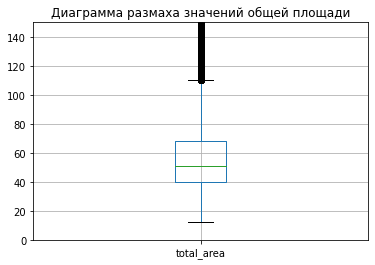

In [49]:
# Диаграмма размаха
plt.ylim(0, 150)
plt.title('Диаграмма размаха значений общей площади')
data.boxplot(column='total_area', );

По диаграмме размаха будем считать, что выбросы находятся ниже 10 и выше 120. 

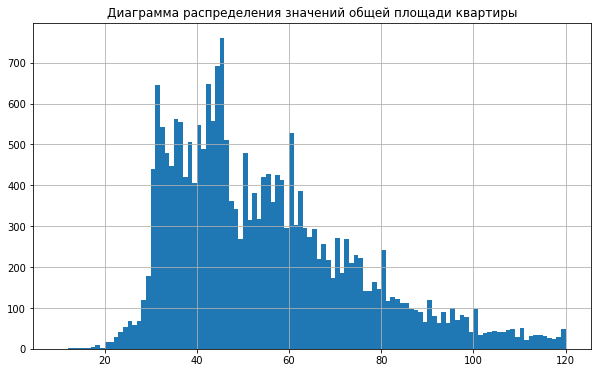

In [50]:
plt.title('Диаграмма распределения значений общей площади квартиры')
data.total_area.hist(bins=110, 
                     range = (10, 120), 
                     figsize=(10, 6));

**Вывод:** на диаграмме хорошо просматриваются 4 пика: значения около 33, 45, 50 и 60, это значит, что квартир с такими площадями было продано больше всего. В целом гистограмма имеет вид распределения Пуассона.

##### жилая площадь

In [51]:
data.living_area.describe()

count    23011.000000
mean        32.715995
std         16.554477
min          2.000000
25%         18.200000
50%         30.000000
75%         42.000000
max        147.200000
Name: living_area, dtype: float64

Медианное значение жилой площади равно 30, среднее арифметическре - 32.7. Межквартильный интервал находится в пределах значений 18.2 и 42.

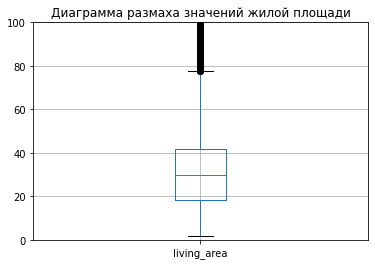

In [52]:
plt.ylim(0, 100)
plt.title('Диаграмма размаха значений жилой площади')
data.boxplot(column='living_area');

По диаграмме размаха будем считать, что выбросы находятся ниже 0 и выше 80. 

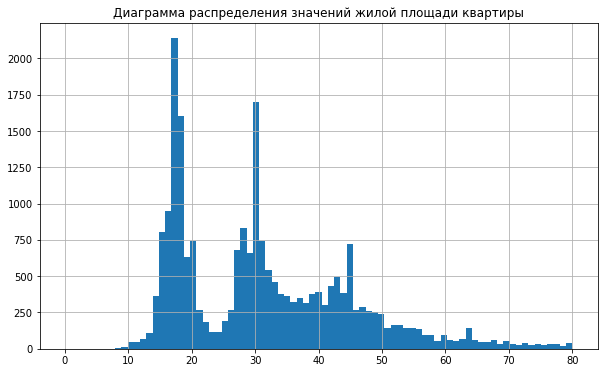

In [53]:
plt.title('Диаграмма распределения значений жилой площади квартиры')
data.living_area.hist(bins=81, 
                      range = (0, 80), 
                      figsize=(10, 6));

**Вывод:** на диаграмме хорошо просматриваются 3 пика: значения около 17, 30 и 45, это значит, что квартир, имеющих такие жилые площади, было продано больше всего. Ожидаемый вид распределения - распределение Пуассона, но провал около 23 вызывает вопросы, возможно произошел сбой в системе сбора данных, либо же квартир с жилой площадью от 21 до 26 действительно меньше.

##### площадь кухни

In [54]:
data.kitchen_area.describe()

count    23011.000000
mean         9.964268
std          4.435205
min          0.000000
25%          7.100000
50%          9.000000
75%         11.120000
max         40.000000
Name: kitchen_area, dtype: float64

Медианное значение площади кухни равно 9, среднее арифметическре - 10. Межквартильный интервал находится в пределах значений 7.1 и 11.1.

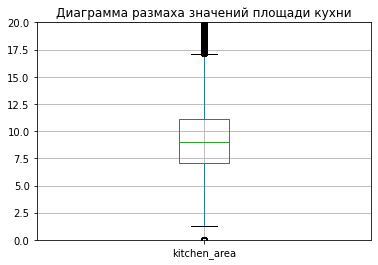

In [55]:
plt.ylim(0, 20)
plt.title('Диаграмма размаха значений площади кухни')
data.boxplot(column='kitchen_area');

По диаграмме размаха будем считать, что выбросы находятся ниже 1 и выше 18.

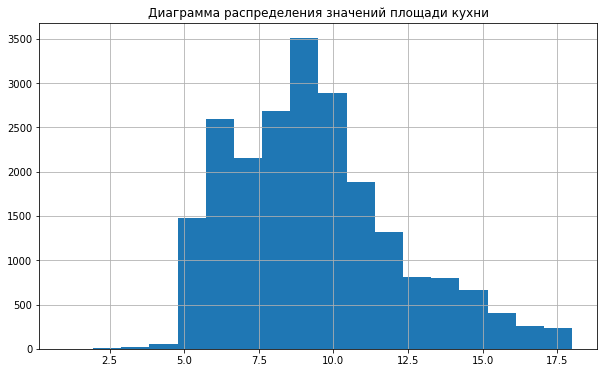

In [56]:
plt.title('Диаграмма распределения значений площади кухни')
data.kitchen_area.hist(bins=18, 
                       range = (1, 18),
                       figsize=(10, 6));

**Вывод:** вид распределения диаграммы - распределение Пуассона, большая часть проданных квартир имеет плошадь кухни равную 9.

##### цена объекта

In [57]:
data.last_price.describe()

count    2.301100e+04
mean     5.636602e+06
std      3.838757e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.600000e+06
75%      6.550000e+06
max      3.000000e+07
Name: last_price, dtype: float64

Медианное значение цены на момент снятия публикации равно 4_600_000, среднее арифметическре - 5_636_602. Межквартильный интервал находится в пределах значений 3_400_000 и 6_550_000.

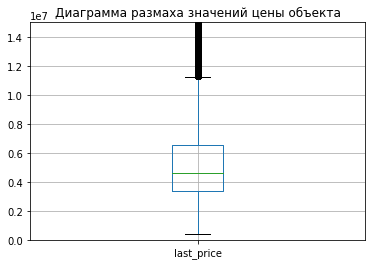

In [58]:
plt.ylim(0, 15_000_000)
plt.title('Диаграмма размаха значений цены объекта')
data.boxplot(column='last_price');

По диаграмме размаха будем считать, что выбросы находятся ниже 0 и выше 12_000_000.

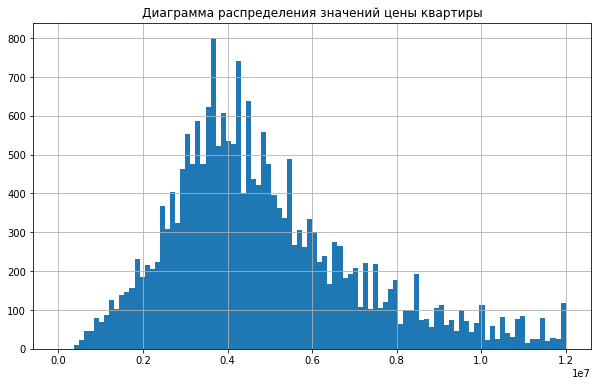

In [59]:
plt.title('Диаграмма распределения значений цены квартиры')
data.last_price.hist(bins=100, 
                     range = (0, 12_000_000), 
                     figsize=(10, 6));

**Вывод:** диаграмма имеет вид колокола, цена, по которой чаще всего продают квартиры, находится в диапозоне от 3_500_000 до 4_500_000. 

##### количество комнат

In [60]:
data.rooms.describe()

count    23011.000000
mean         2.019512
std          0.981671
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: rooms, dtype: float64

Медианна кол-ва комнат равна 2, среднее арифметическре - 2. Межквартильный интервал находится в пределах значений 1 и 3.

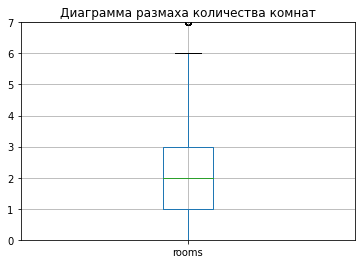

In [61]:
plt.ylim(0, 7)
plt.title('Диаграмма размаха количества комнат')
data.boxplot(column='rooms');

По диаграмме размаха будем считать, что выбросы находятся ниже 0 и выше 6.

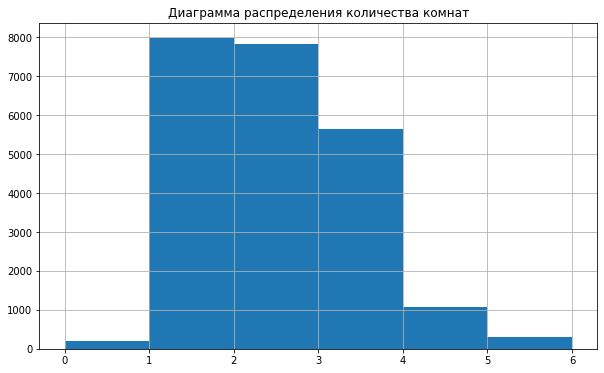

In [62]:
plt.title('Диаграмма распределения количества комнат')
data.rooms.hist(bins=6, 
                range = (0, 6), 
                figsize=(10, 6));

**Вывод:** диаграмма имеет вид распределения Пуассона, больше всего проданных квартир имели 1 и 2 комнаты. Меньше всего было продано студий.

##### высота потолков

In [63]:
data.ceiling_height.describe()

count    23011.000000
mean         2.688794
std          0.204629
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          5.000000
Name: ceiling_height, dtype: float64

Медианное значение высоты потолков равно 2.65, среднее арифметическре - 2.7. Межквартильный интервал находится в пределах значений 2.6 и 2.7.

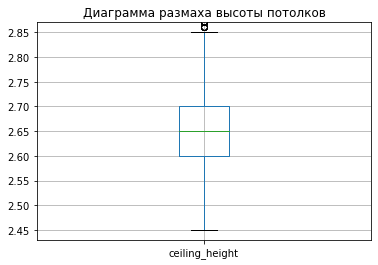

In [64]:
plt.ylim(2.43, 2.87)
plt.title('Диаграмма размаха высоты потолков')
data.boxplot(column='ceiling_height');

По диаграмме размаха будем считать, что выбросы находятся ниже 2.45 и выше 2.85.

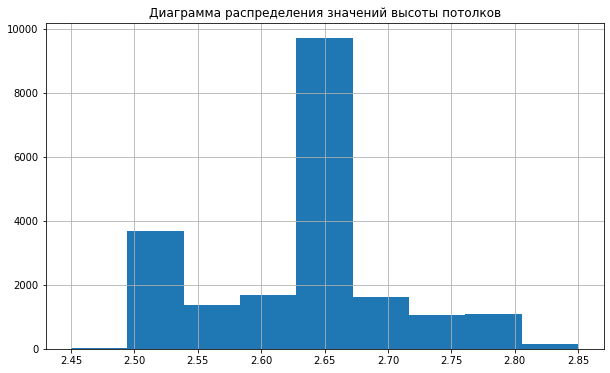

In [65]:
plt.title('Диаграмма распределения значений высоты потолков')
data.ceiling_height.hist(bins=9, 
                         range = (2.45, 2.85), 
                         figsize=(10, 6));

**Вывод:** чаще всего встречающаяся высота потолков равна 2.65.

##### этаж квартиры

In [66]:
data.floor.describe()

count    23011.000000
mean         5.878841
std          4.863009
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         27.000000
Name: floor, dtype: float64

Медианное значение этажа, на котором находилась квартира равно 4, среднее арифметическре - 6. Межквартильный интервал находится в пределах значений 2 и 8.

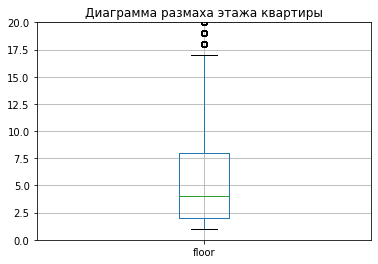

In [67]:
plt.ylim(0, 20)
plt.title('Диаграмма размаха этажа квартиры')
data.boxplot(column='floor');

По диаграмме размаха будем считать, что выбросы находятся ниже 1 и выше 18.

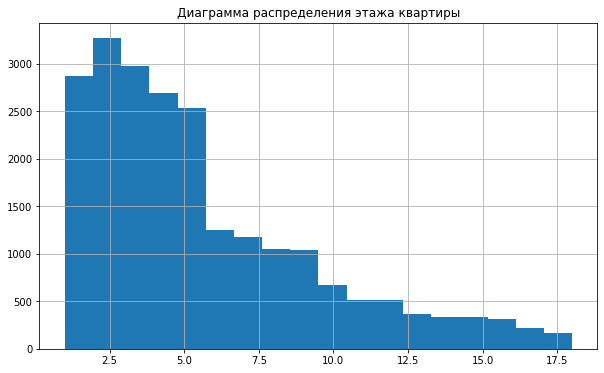

In [68]:
plt.title('Диаграмма распределения этажа квартиры')
data.floor.hist(bins=18, 
                range = (1, 18), 
                figsize=(10, 6));

**Вывод:** диаграмма имеет вид распределения Пуассона, больше всего проданных квартир находились на 2 и 3 этажах.

##### тип этажа квартиры («первый», «последний», «другой»)

In [69]:
data.type_of_floor.describe()

count      23011
unique         3
top       другой
freq       16926
Name: type_of_floor, dtype: object

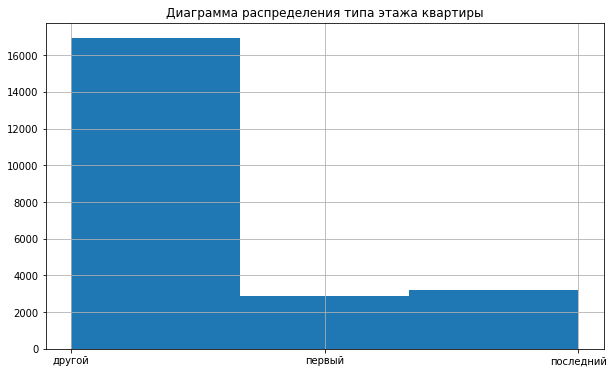

In [70]:
plt.title('Диаграмма распределения типа этажа квартиры')
data.type_of_floor.hist(bins=3, 
                        figsize=(10, 6));

**Вывод:** категория этажей `'другой'` стала самой многочисленной. Квартир, находящихся на первом этаже, меньше всего.

##### общее количество этажей в доме

In [71]:
data.floors_total.describe()

count    23011.000000
mean        10.709661
std          6.552901
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         29.000000
Name: floors_total, dtype: float64

Медианное значение общего кол-ва этажей в доме равно 9, среднее арифметическре - 11. Межквартильный интервал находится в пределах значений 5 и 16.

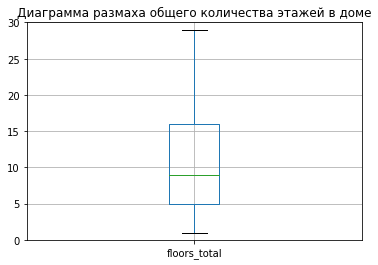

In [72]:
plt.ylim(0, 30)
plt.title('Диаграмма размаха общего количества этажей в доме')
data.boxplot(column='floors_total');

По диаграмме размаха будем считать, что выбросы находятся выше 30.

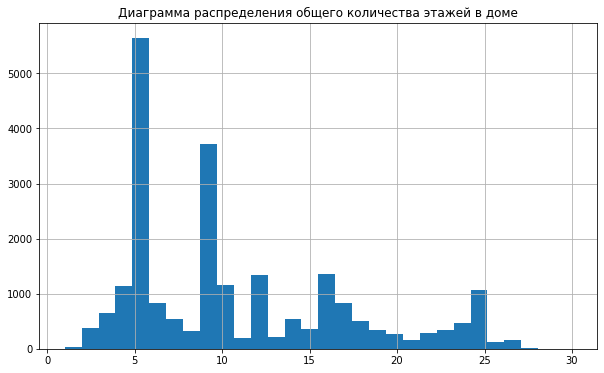

In [73]:
plt.title('Диаграмма распределения общего количества этажей в доме')
data.floors_total.hist(bins=30, 
                       range = (1, 30), 
                       figsize=(10, 6));

**Вывод:** больше всего домов, в которых продают квартиры, имеют 5 и 9 этажей.

##### расстояние до центра города в метрах

In [74]:
data.cityCenters_nearest.describe()

count    17536.000000
mean     14381.170392
std       8595.062847
min        208.000000
25%       9626.000000
50%      13220.000000
75%      16360.250000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

Медианное значение расстояние до центра города в метрах равно 13220, среднее арифметическре - 14381.2. Межквартильный интервал находится в пределах значений 9626 и 16360.25.

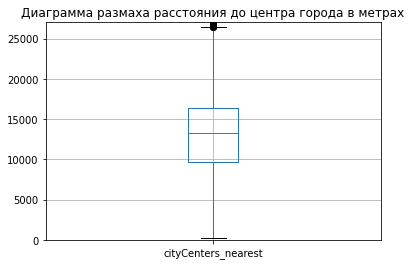

In [75]:
plt.ylim(0, 27_000)
plt.title('Диаграмма размаха расстояния до центра города в метрах')
data.boxplot(column='cityCenters_nearest');

По диаграмме размаха будем считать, что выбросы находятся ниже 0 и выше 27_000.

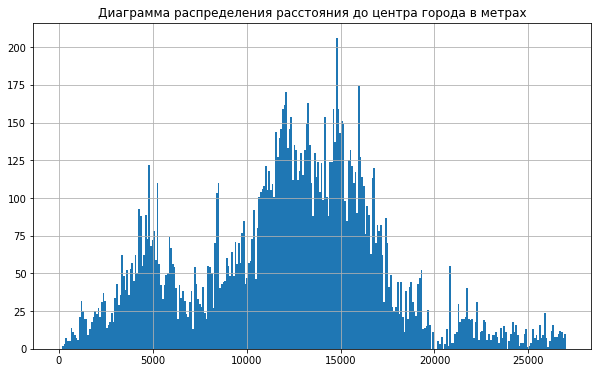

In [76]:
plt.title('Диаграмма распределения расстояния до центра города в метрах')
data.cityCenters_nearest.hist(bins=300, 
                              range = (0, 27_000), 
                              figsize=(10, 6));

**Вывод:** на диаграмме видны 2 пика: в районе 5000 и 15000, также есть провал в пределах 6000, стоит отметить, что у этого столбца есть пропуски.

##### расстояние до ближайшего аэропорта

In [77]:
data.airports_nearest.describe()

count    17516.000000
mean     28861.167047
std      12744.699461
min          0.000000
25%      18442.750000
50%      26885.500000
75%      37412.000000
max      84869.000000
Name: airports_nearest, dtype: float64

Медианное значение расстояние до до ближайшего аэропорта равно 26885.5, среднее арифметическре - 28861.1. Межквартильный интервал находится в пределах значений 18442.75 и 37412.

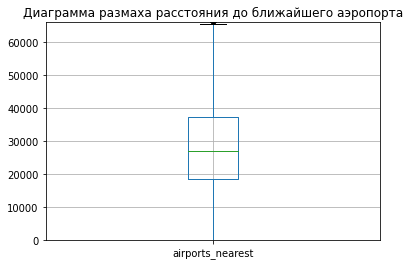

In [78]:
plt.ylim(0, 66_000)
plt.title('Диаграмма размаха расстояния до ближайшего аэропорта')
data.boxplot(column='airports_nearest');

По диаграмме размаха будем считать, что выбросы находятся ниже 0 и выше 66_000.

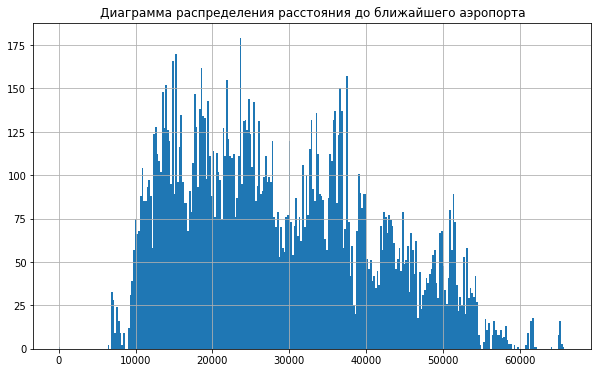

In [79]:
plt.title('Диаграмма распределения расстояния до ближайшего аэропорта')
data.airports_nearest.hist(bins=300, 
                           range = (0, 66_000), 
                           figsize=(10, 6));

**Вывод:** чаще всего дорога до аэропорта занимает от 15_000 до 28_000.

##### расстояние до ближайшего парка

In [80]:
data.parks_nearest.describe()

count    7689.000000
mean      493.681623
std       341.654397
min         1.000000
25%       289.000000
50%       456.000000
75%       614.000000
max      3190.000000
Name: parks_nearest, dtype: float64

Медианное значение расстояние до до ближайшего парка равно 456, среднее арифметическре - 493.7. Межквартильный интервал находится в пределах значений 289 и 614.

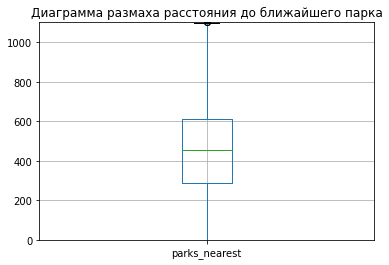

In [81]:
plt.ylim(0, 1100)
plt.title('Диаграмма размаха расстояния до ближайшего парка')
data.boxplot(column='parks_nearest');

По диаграмме размаха будем считать, что выбросы находятся ниже 0 и выше 1100.

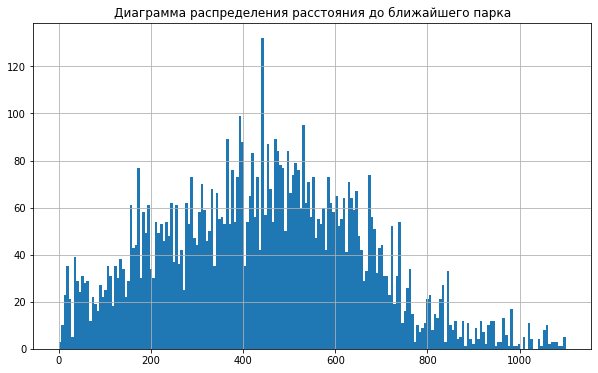

In [82]:
plt.title('Диаграмма распределения расстояния до ближайшего парка')
data.parks_nearest.hist(bins=200, 
                        range = (0, 1100), 
                        figsize=(10, 6));

**Вывод:** чаще всего дорога до ближайшего парка занимает от 400 до 500.

##### день и месяц публикации объявления

In [83]:
data.day_of_week_exposition.describe()

count    23011.000000
mean         2.565338
std          1.788885
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: day_of_week_exposition, dtype: float64

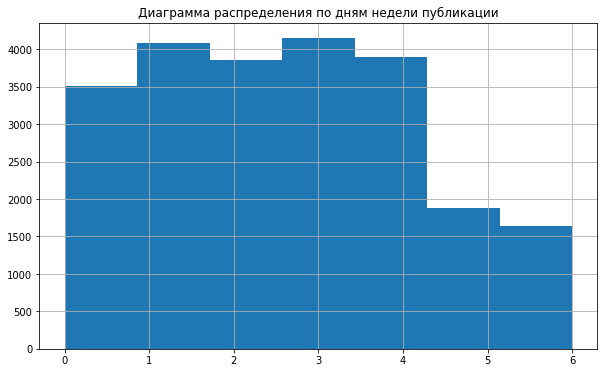

In [84]:
plt.title('Диаграмма распределения по дням недели публикации')
data.day_of_week_exposition.hist(bins=7, 
                                 range = (0, 6), 
                                 figsize=(10, 6));

**Вывод:** в основном объявления о продаже публикуют в будние дни, чаще всего во вторник и в четверг. Меньше всего публикаций отмечено в воскресенье.

In [85]:
data.month_exposition.describe()

count    23011.000000
mean         6.403285
std          3.492125
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month_exposition, dtype: float64

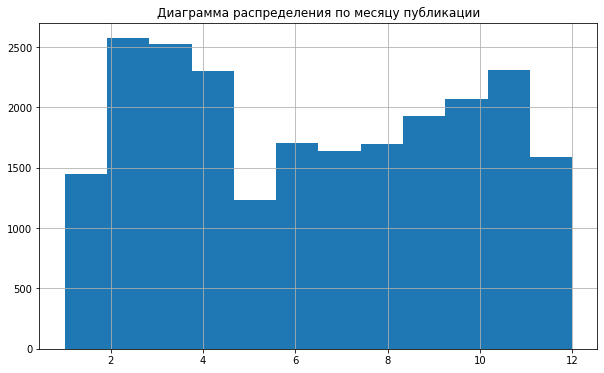

In [86]:
plt.title('Диаграмма распределения по месяцу публикации')
data.month_exposition.hist(bins=12, 
                           range = (1, 12), 
                           figsize=(10, 6));

**Вывод:** чаще всего объявления о продаже публикуют в феврале, марте, апреле и ноябре, меньше всего: в мае, летом и в канун Нового года.

#### Задание: изучите, как быстро продавались квартиры (столбец days_exposition).

In [87]:
data.days_exposition.describe()

count    19974.000000
mean       178.745619
std        217.214216
min          1.000000
25%         45.000000
50%         94.000000
75%        228.000000
max       1580.000000
Name: days_exposition, dtype: float64

Медианное значение размещения объявления о продаже равно 94 дня, среднее арифметическре - 178.7.

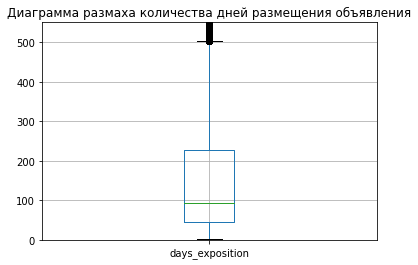

In [88]:
plt.ylim(0, 550)
plt.title('Диаграмма размаха количества дней размещения объявления')
data.boxplot(column='days_exposition');

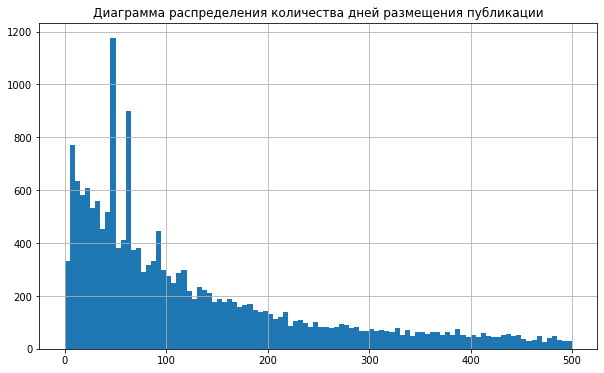

In [89]:
plt.title('Диаграмма распределения количества дней размещения публикации')
data.days_exposition.hist(bins=100, 
                          range = (0, 500), 
                          figsize=(10, 6));

**Вывод:** обычно продажа занимает от 45 до 228 дней, продажи, которые занимают более 502 дней, являются необычно долгими (граница от 45 до 228 является межквартильным размахом: Q1 и Q3, границу выбросов обозначила как 1.5IQR).

#### Задание: какие факторы больше всего влияют на общую (полную) стоимость объекта? 

Постройте графики, которые покажут зависимость цены `'last_price'` от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы.
 - общей площади `'total_area'`;
 - жилой площади `'living_area'`;
 - площади кухни `'kitchen_area'`;
 - количество комнат `'rooms'`;
 - типа этажа, на котором расположена квартира (первый, последний, другой) `'type_of_floor'`;
 - даты размещения (день недели, месяц, год) `'first_day_exposition'`;

По диаграмме размаха в пункте 4.1 будем считать, что выбросы в столбце `'total_area'` находятся ниже 10 и выше 120.

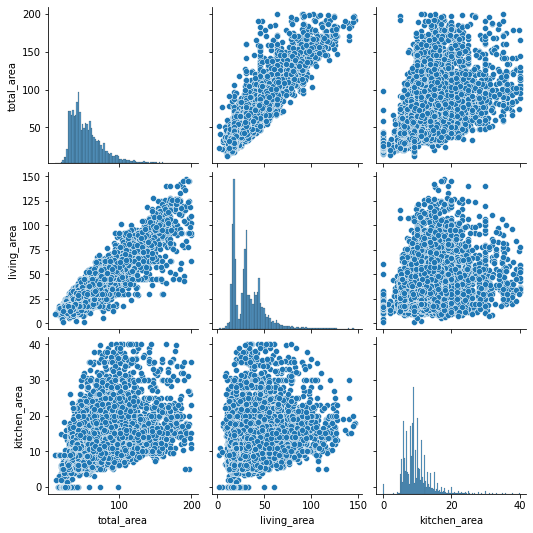

In [90]:
data_last = data[['total_area', 'living_area', 'kitchen_area']]
sns.pairplot(data_last);

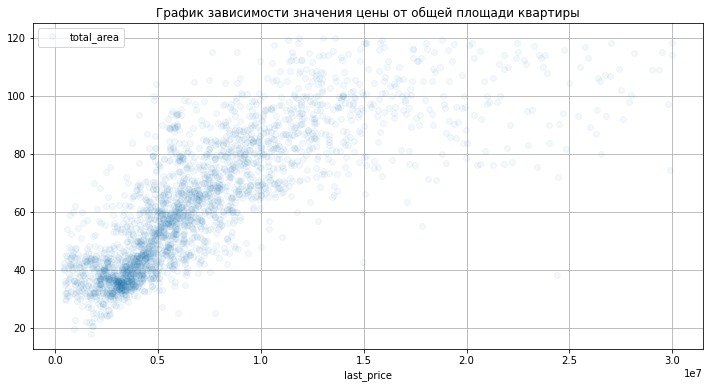

In [91]:
(data
    .query('10 <= total_area <= 120')
    .pivot_table(index='last_price', values='total_area', aggfunc='median')
    .plot(title='График зависимости значения цены от общей площади квартиры',
          style='o',
          grid=True, 
          alpha=0.05,
          figsize=(12, 6))
);

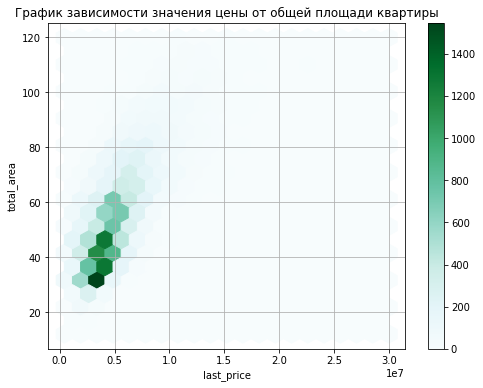

In [92]:
(data
    .query('10 < total_area < 120')
    .plot(title='График зависимости значения цены от общей площади квартиры',
          x='last_price', 
          y='total_area', 
          kind='hexbin', 
          gridsize=20, 
          figsize=(8, 6), 
          sharex=False, 
          grid=True));

In [93]:
data.last_price.corr(data.total_area)

0.7815569991480728

**Вывод:** в самой густой зоне находятся квартиры с общей площадью от 30 до 50 и ценой до 5_000_000. Наблюдается следующая тенденция: чем больше общая площадь квартиры, тем выше цена, это подтверждвет и коэффициент корреляции - он положительный, равен 0.78.

По диаграмме размаха в пункте 4.2 будем считать, что выбросы в столбце `'living_area'` находятся выше 80.

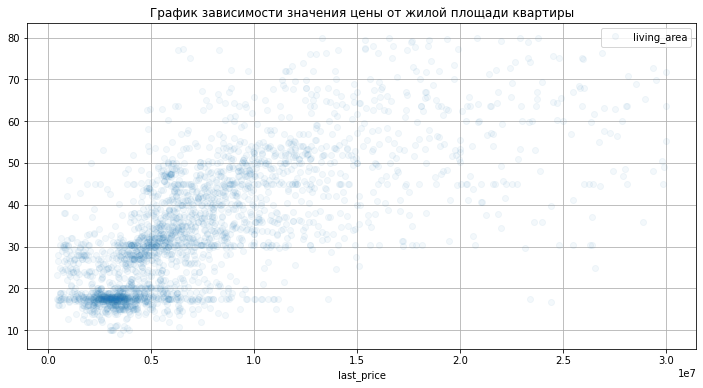

In [94]:
(data
    .query('living_area <= 80')
    .pivot_table(index='last_price', values='living_area', aggfunc='median')
    .plot(title='График зависимости значения цены от жилой площади квартиры',
          style='o',
          grid=True, 
          alpha=0.05,
          figsize=(12, 6))
);

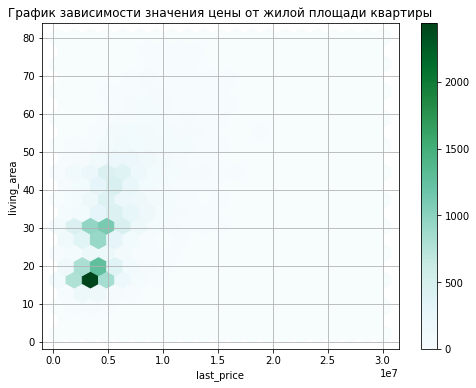

In [95]:
(data
    .query('living_area <= 80')
    .plot(title='График зависимости значения цены от жилой площади квартиры',
          x='last_price', 
          y='living_area', 
          kind='hexbin', 
          gridsize=20, 
          figsize=(8, 6), 
          sharex=False, 
          grid=True)
);

In [96]:
data.last_price.corr(data.living_area)

0.6515669261288658

**Вывод:** в самой густой зоне находятся квартиры с жилой площадью от 15 до 20 и ценой до 5_000_000. Наблюдается следующая тенденция: чем больше жилая площадь квартиры, тем выше цена, это подтверждвет и коэффициент корреляции - он положительный, равен 0.65.

По диаграмме размаха в пункте 4.3 будем считать, что выбросы в столбце `'kitchen_area'` находятся ниже 1 и выше 18.

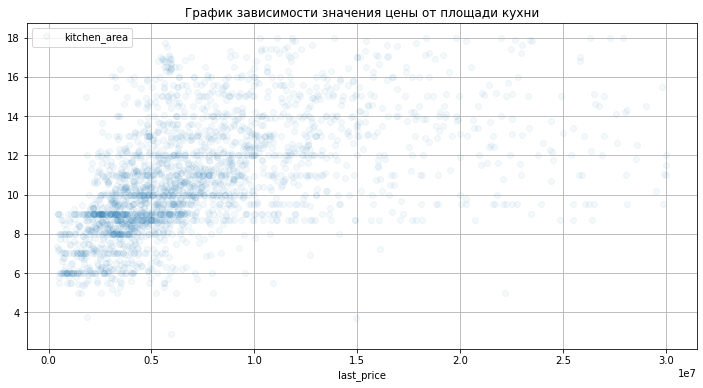

In [97]:
(data
    .query('1 <= kitchen_area <= 18')
    .pivot_table(index='last_price', values='kitchen_area', aggfunc='median')
    .plot(title='График зависимости значения цены от площади кухни',
          style='o',
          grid=True, 
          alpha=0.05,
          figsize=(12, 6))
);

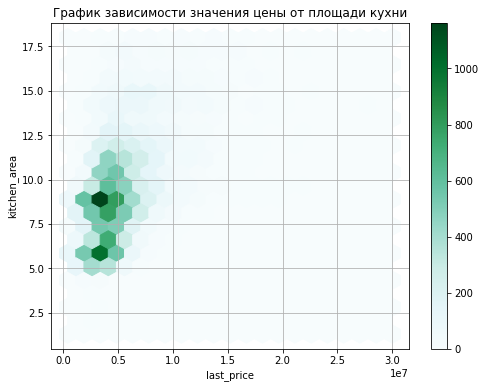

In [98]:
(data
    .query('1 <= kitchen_area <= 18')
    .plot(title='График зависимости значения цены от площади кухни',
          x='last_price', 
          y='kitchen_area', 
          kind='hexbin', 
          gridsize=20, 
          figsize=(8, 6), 
          sharex=False, 
          grid=True)
);

In [99]:
data.last_price.corr(data.kitchen_area)

0.5654201157163078

**Вывод:** в самой густой зоне находятся квартиры с площадью кухни от 7,5 до 9,5 и ценой до 6_000_000. Наблюдается следующая тенденция: чем больше площадь кухни квартиры, тем выше цена, это подтверждвет и коэффициент корреляции - он положительный, равен 0.56.

По диаграмме размаха в пункте 4.5 будем считать, что выбросы в столбце 'rooms' находятся выше 6.

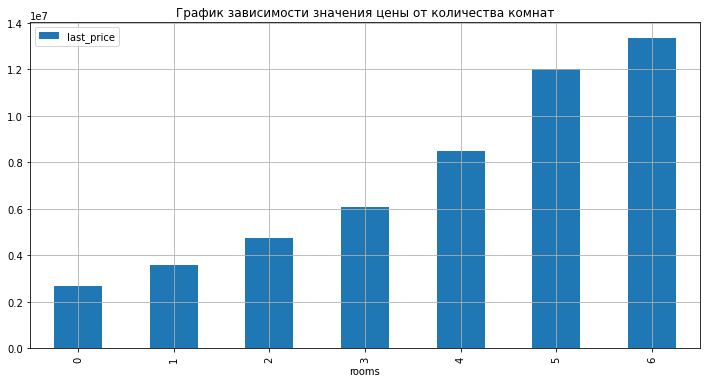

In [100]:
(data
    .query('rooms <= 6')
    .pivot_table(index='rooms', values='last_price', aggfunc='median')
    .plot(title='График зависимости значения цены от количества комнат',
          kind='bar',
          grid=True, 
          figsize=(12, 6))
);

In [101]:
data.last_price.corr(data.rooms)

0.49777107949176785

**Вывод:** наблюдается следующая тенденция: чем больше кол-во комнат в квартире, тем выше цена, это подтверждвет и коэффициент корреляции - он положительный, равен 0.5.

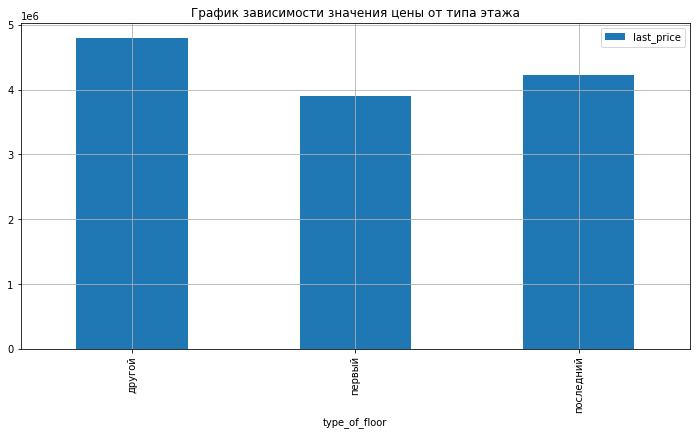

In [102]:
(data
    .pivot_table(index='type_of_floor', values='last_price', aggfunc='median')
    .plot(title='График зависимости значения цены от типа этажа',
          kind='bar',
          grid=True, 
          figsize=(12, 6))
);

**Вывод:** самые дешевые квартиры находятся на первом этаже, более дорогие - на последнем, самые дорогие имеют не первый и не последний этажи.

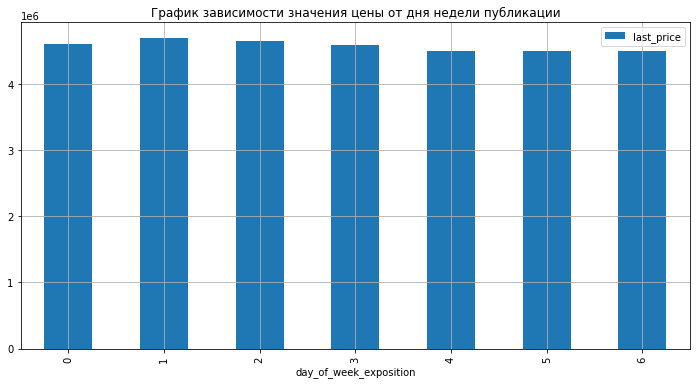

In [103]:
(data
    .pivot_table(index='day_of_week_exposition', values='last_price', aggfunc='median')
    .plot(title='График зависимости значения цены от дня недели публикации',
          kind='bar',
          grid=True, 
          figsize=(12, 6))
);

**Вывод:** зависимость цены от дня недели, в который была сделана публикация, выражена слабо, однако квартиры, опубликованные в понедельник, вторник, среду и в четверг стоят немного дороже, самые дорогие квартиры были опубликованы во вторник, самые дешевые - в пятницу, субботу и воскресенье.

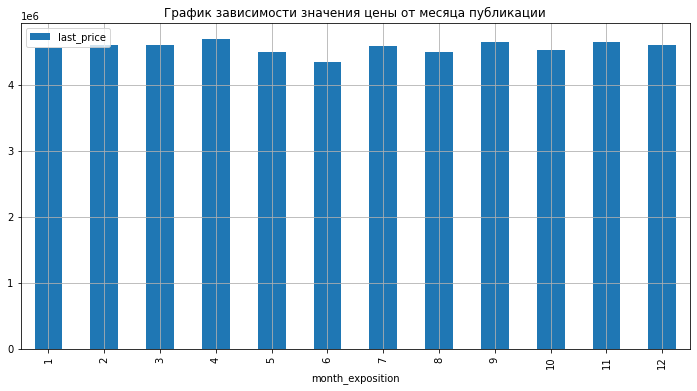

In [105]:
(data
    .pivot_table(index='month_exposition', values='last_price', aggfunc='median')
    .plot(title='График зависимости значения цены от месяца публикации',
          kind='bar',
          grid=True, 
          figsize=(12, 6))
);

**Вывод:** зависимость цены от месяца, в который была сделана публикация, выражена слабо. В апреле были опубликованы самые дорогие квартиры, в июне - самые дешевые. Это может быть связано с тем, что количество публикаций летом резко уменьшается.

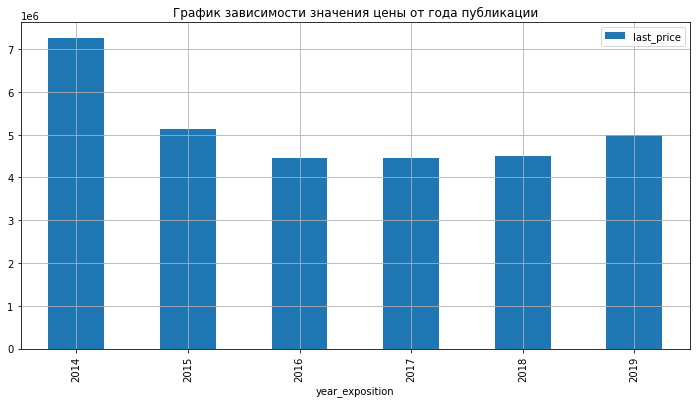

In [107]:
(data
    .pivot_table(index='year_exposition', values='last_price', aggfunc='median')
    .plot(title='График зависимости значения цены от года публикации',
          kind='bar',
          grid=True, 
          figsize=(12, 6))
);

**Вывод:** зависимость цены от года публикации выражена слабо, с 2014 г. по 2017 г. наблюдается стабильное снижение цен на квартиры, но с 2018 по 2019 наблюдается обратная тенденция. 

**Общий вывод по 4.15:** в этом разделе было изучено влияние следующих факторов на цену квартиры:
- общая площадь;
- жилая площадь;
- площадь кухни;
- кол-во комнат;
- тип этажа;
- дата размещения (день недели, месяц, год).

Наибольшее влияние на цену квартиры оказывает ее общая площадь, у этого показателя самый высокий коэф. корреляции: 0.78, чуть меньшее влияние оказывают жилая площадь и площадь кухни с корреляцией 0.65 и 0.56.  Небольшое влияние оказывает кол-во комнат, коэффициент корреляции равен 0.5. Положительная корреляция характерна для прямой зависимости, то есть чем выше значение этих параметров, тем больше будет и цена.

Так же самые дорогие квартиры имеют не первый и не последний этаж. Квартиры на первом этаже самые дешевые. 

Что касается даты размещения, здесь не все так одназначно, взаимосвязь факторов выражена слабо. Скорее всего есть другие обстоятельства, влияющие на эту зависимость. В будни, кроме пятницы, были опубликованы самые дорогие квартиры, но дороже они тех, которые были опубликованы в выходные дни, в среднем на 1-2%. В начале года, весной, опубликованные квартиры стоят больше, но и количество публикуемых квартир в тот же период тоже больше. Скорее всего цена зависит не столько от года публикации, сколько от дополнительных факторов, появляющихся в новом году. 

####  Задание: посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. 

In [109]:
locality_name_max_count = data.pivot_table(
    index='locality_name', values='price_one_square', aggfunc=['count', 'median'])
locality_name_max_count.columns = ['count', 'price_one_square_median']

In [110]:
locality_name_max_count = locality_name_max_count.sort_values(by='count', ascending=False).head(10)
display(locality_name_max_count)

,count,price_one_square_median
locality_name,,
Санкт-Петербург,15133,104145.833333
поселок Мурино,550,85878.462169
поселок Шушары,438,76876.172608
Всеволожск,396,65789.473684
Пушкин,360,99865.712506
Колпино,337,74722.222222
поселок Парголово,326,91780.224134
Гатчина,307,67796.610169
деревня Кудрово,299,91860.465116


In [111]:
locality_name_max_count.sort_values(by='price_one_square_median', ascending=False)

,count,price_one_square_median
locality_name,,
Санкт-Петербург,15133,104145.833333
Пушкин,360,99865.712506
деревня Кудрово,299,91860.465116
поселок Парголово,326,91780.224134
поселок Мурино,550,85878.462169
поселок Шушары,438,76876.172608
Колпино,337,74722.222222
Гатчина,307,67796.610169
Всеволожск,396,65789.473684


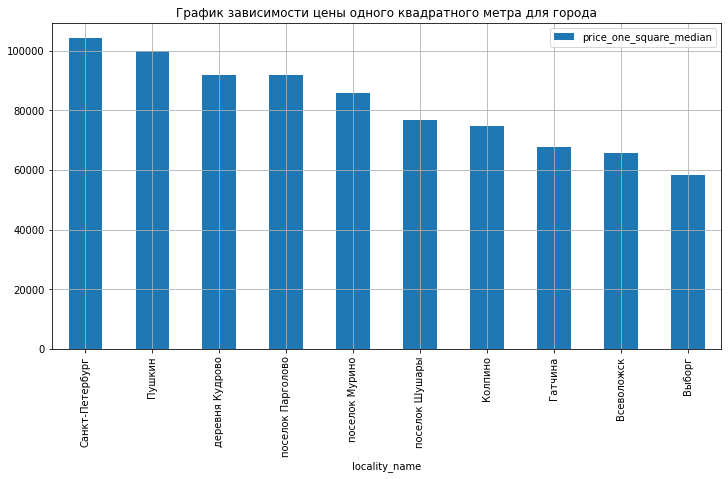

In [112]:
(locality_name_max_count
    .sort_values(by='price_one_square_median', ascending=False)
    .plot(title='График зависимости цены одного квадратного метра для города',
          y='price_one_square_median',
          kind='bar',
          grid=True, 
          figsize=(12, 6))
);

**Вывод:** населённый пункт с самой высокой стоимостью квадратного метра - Санкт-Петербург, с самой низкой - Выборг.

#### Задание: Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `'locality_name'` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города.

In [113]:
data['price_km'] = data.last_price / data.cityCenters_nearest_km
data[data.locality_name == 'Санкт-Петербург'].price_km.median()

438192.3076923077

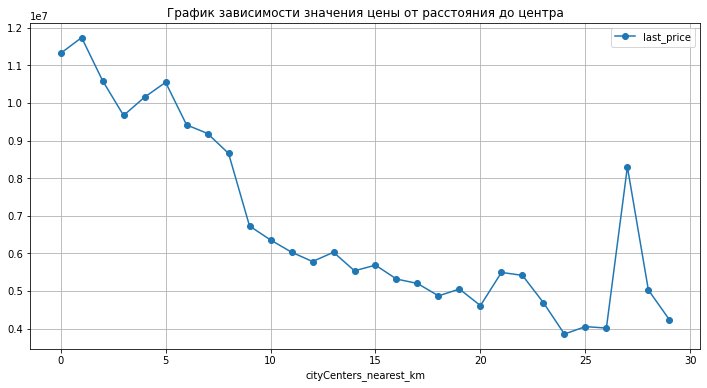

In [114]:
(data
    .query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='cityCenters_nearest_km', values='last_price')   
    .plot(title='График зависимости значения цены от расстояния до центра',
          style='-o',
          grid=True,
          figsize=(12, 6))
);

**Вывод :** средняя цена одного километра в г. Санкт-Петербург равна 438192. Чем ближе квартира находится к центру, тем больше она стоит. Начиная с 5км цена активно начинает снижаться.

### Общий вывод

**1. Обзор данных.**

В каждой строке таблицы - данные о проданных квартирах. Часть колонок описывает хакактеристики самой квартиры: общая площадь квартиры в квадратных метрах, число балконов, высота потолков, площадь кухни в квадратных метрах, жилая площадь в квадратных метрах, свободная планировка, число комнат, квартира-студия, квартира-апартаменты. 

Другая часть рассказывают о ее расположении: название населённого пункта, этаж, кол-во этажей в доме, расстояние до ближайшего аэропорта в метрах, расстояние до центра города, число парков в радиусе 3 км, расстояние до ближайшего парка, число водоёмов в радиусе 3 км, расстояние до ближайшего водоёма. 

Остальные данные - характеристики объявления: дата публикации, сколько дней было размещено обьявление (от публикации до снятия), число фотографий квартиры в объявлении.

**2. Предобработка данных.**

Были обнаружены следующие проблемы в данных:

 - пропущенные значения в колонках:
   - `'ceiling_height'` - 39% от общего кол-ва данных;
   - `'floors_total'` - 0.4% от общего кол-ва данных;
   - `'living_area'` - 8% от общего кол-ва данных; 
   - `'is_apartment'` - 88% от общего кол-ва данных;
   - `'kitchen_area'` - 10% от общего кол-ва данных;
   - `'balcony'` - 49% от общего кол-ва данных;
   - `'locality_name'` - 0.2% от общего кол-ва данных;
   - `'airports_nearest'` - 23% от общего кол-ва данных;
   - `'cityCenters_nearest'` - 23% от общего кол-ва данных;
   - `'parks_around3000'` - 23% от общего кол-ва данных;
   - `'parks_nearest'` - 66% от общего кол-ва данных;
   - `'ponds_around3000'` - 23% от общего кол-ва данных;
   - `'ponds_nearest'` - 62% от общего кол-ва данных;
   - `'days_exposition'` - 13% от общего кол-ва данных.
 - данные-аномалии: 
     - значения высоты потолка в диапозоне от 8м до 100м;
     - строки, в которых значение жилой площади было больше значения общей площади.
 - неявные дубликаты в столбце `'locality_name'`.

Так же в столбцах  `'first_day_exposition'`, `'floors_total'`, `'balcony'`, `'parks_around3000'`, `'ponds_around3000'`, `'days_exposition'` требовалось заменить типы данных.

Пропуски в столбце `'ceiling_height'` заменены медианным значением высоты потолков, в `'living_area'` и `'kitchen_area'` - медианой относительно кол-ва комнат в квартире. 

Столбец `'is_apartment'` удален из-за слишком большого кол-ва пропусков.

В столбцах `'balcony'`, `'parks_around3000'`, `'ponds_around3000'`, `'days_exposition'` и `'kitchen_area'` (в случае, когда квартира являлась студией) пропуски заменены на 0.

Строки, которые имели пропуски в столбцах `'floors_total'` и `'locality_name'`, удалены.

В группе столбцов `'cityCenters_nearest'`, `'airports_nearest'`, `'parks_nearest'` и `'ponds_nearest'` пропуски оставлены за-за отсутствия логичной замены.

В столбце `'first_day_exposition'` тип `'object'` приведен к типу `'datetime'`, в остальных столбцах, требующих замены типа данных, тип `'float'` приведен к типу `'int'`.

Неявные дубликаты в столбце `'locality_name'`, аномальные значения в `'ceiling_height'` и строки, в которых значение жилой площади было больше значения общей площади были устранены.

Так же в таблицу были добавлены новые колонки со следующими значениями: цена одного квадратного метра, день публикации объявления, месяц публикации объявления, год публикации объявления, тип этажа квартиры (значения — «первый», «последний», «другой»), расстояние в км до центра города.

**3. Исследовательский анализ данных.**

Изучены и описаны следующие параметры:
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- этаж квартиры;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего аэропорта;
- расстояние до ближайшего парка;
- день и месяц публикации объявления.

Большинство квартир имеют следующие характеристики: общая площадь, равная 46, жилая площадь, равная 17, плошадь кухни - 9, цена в диапозпне от 3_500_000 до 4_500_000, 1 или 2 комнаты, высота потолков 2.65м, 2 или 3 этаж, с общим кол-вом этажей 5 или 9, с расстоянием до центра 15 км, до аэропорта 15-25 км, до ближайшего парка 450м, опубликованна в будни с февраля по апрель.

Обычно продажа квартиры занимает от 45 до 228 дней. Больше всего на стоимость квартиры влияет ее общая площадь. Так же известна зависимость цены от следующих параметров: общая площадь, жилая площадь, площадь кухни, кол-во комнат - чем выше значение этих параметров, тем больше стоимость квартиры, к тому же чем ближе квартира находится к центру, тем больше она стоит.

Населённый пункт с самой высокой стоимостью квадратного метра - Санкт-Петербург: 104_146/кв м. Средняя цена одного километра к центру в г. Санкт-Петербург равна 438_192.